In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import pydot
import h5py
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from tensorflow.keras import applications
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras.optimizers import SGD
import random
%matplotlib inline
from time import time


# Reading Data 

In [0]:
def load_dataset():
    path_to_train = "assignment3_train.h5"
    path_to_test = "assignment3_test.h5"

    train_dataset = h5py.File(path_to_train, "r")
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test, "r")
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # reshape y from (samples, ) to (1, samples)
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_x.shape[0]))

    # transpose y
    train_y = train_y.T
    test_y = test_y.T

    return train_x, train_y, test_x, test_y

# Data Preprocessing

In [0]:
def preprocess_data():
    train_x, train_y, test_x, test_y = load_dataset()

    # Normalize image vectors
    train_x = train_x/255.
    test_x = test_x/255.

    print ("number of training examples = " + str(train_x.shape[0]))
    print ("number of test examples = " + str(test_x.shape[0]))

    print ("X_train shape: " + str(train_x.shape))
    print ("Y_train shape: " + str(train_y.shape))
    print ("X_test shape: " + str(test_x.shape))
    print ("Y_test shape: " + str(test_y.shape))

    return train_x, train_y, test_x, test_y

In [67]:
train_x, train_y, test_x, test_y = preprocess_data()

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


In [0]:
input_shape = (64,64,3)

# Show Data 

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


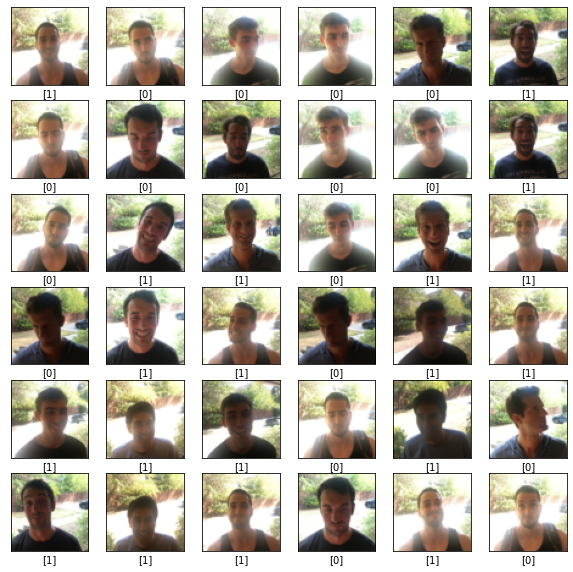

In [69]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(600,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_x[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_y[image_ind])


In [0]:
def plot(training_results, validation_results, results_type, model_name):
    fig = plt.figure(figsize=[8, 6])

    plt.plot(training_results, 'r', linewidth=3.0)
    plt.plot(validation_results, 'b', linewidth=3.0)
    plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel(results_type, fontsize=16)
    plt.title(results_type + ' of ' + model_name, fontsize=16)

# CNN Model 

In [0]:
def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in tensorflow.keras
    """
    #Start Code Here, Make CNN by using tf.keras.layers, put last layer into tf.keras.models.Model
    model = tf.keras.Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='Same', input_shape=(64,64,3)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='Same'))

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='Same'))

    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    #Output Layer
    # Sigmoid because it is a binary classification problem output (0,1)
    model.add(Dense(units = 1,kernel_initializer="uniform", activation='sigmoid'))
    #End Code Here
    
    return model

# Test Models

In [0]:
def plot_accuracy(history, model_name):
    plot(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', model_name)

In [0]:
def plot_loss(history, model_name):
    plot(history.history['loss'], history.history['val_loss'], 'Loss', model_name)

In [0]:
def test_model(model, model_name, epochs=10, print_summary=True, plot_results=True):
    train_x, train_y, test_x, test_y = preprocess_data()

    x_tr, x_val, y_tr, y_val = train_test_split(train_x, train_y, random_state = 3)

    # TODO Try different optimizers, optimizers hyperparameters, losses
    
    sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
    
    #model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    start = time()
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    if (print_summary):
        model.summary()

    hist = model.fit(x_tr, y_tr, validation_data = (x_val, y_val), verbose=1, epochs=epochs, batch_size=32)
    end = time()
    print("Training time: " + str(end - start))
        
    start = time()
    preds = model.evaluate(test_x, test_y, batch_size=32, verbose=1, sample_weight=None)
    end = time()
    print("Testing time: " + str(end - start))
    print ("Testing Loss = " + str(preds[0]))
    print ("Testing Accuracy = " + str(preds[1]))

    if(plot_results):
        plot_loss(hist, model_name)
        plot_accuracy(hist, model_name)

In [0]:
#redefine this faulty freeze layers method to perform as you studied in the lecture
def freeze(model, number_of_freezed_layers):
    layers = model.layers

    # Freeze the layers except the last 4 layers
    for layer in layers[-number_of_freezed_layers:]:
        layer.trainable = False

   ## Check the trainable status of the individual layers
    for layer in layers:
        print(layer, layer.trainable)

    return model

In [0]:
def test_CNN(epochs=10, print_summary=True, plot_results=True, model_name="CNN"):
    #Call test_model from here with your defined CNN Model
    img_rows, img_cols = 64, 64
    input_shape = (img_rows, img_cols, 3)
    model = HappyModel(input_shape)
    test_model(model, model_name, epochs=10, print_summary=True, plot_results=True)
    return model


# Test Happy Face Model


number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_23 

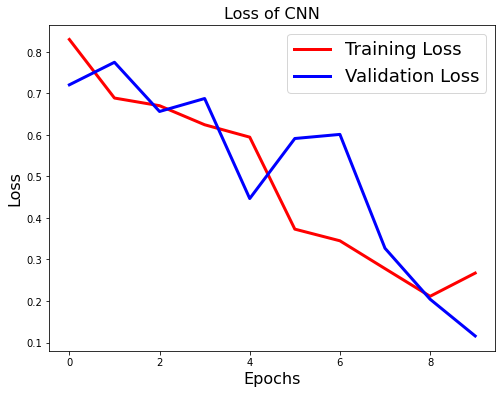

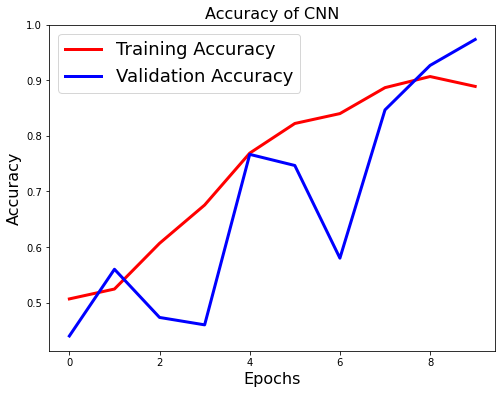

In [99]:
happy_model = test_CNN(epochs=10, print_summary=True, plot_results=True, model_name="CNN")

# RESNET

In [0]:
def test_Resnet(pretrained=True, freeze_layers=False, number_of_freezed_layers=0, epochs=10, print_summary=True, plot_results=True, model_name="ResNet"):
    
    if(pretrained):
        model_name = "Pretrained " + model_name
        base_model = applications.resnet.ResNet50(weights='imagenet', include_top=False,input_tensor=None,input_shape=input_shape, pooling='none')
    else:
        model_name = "Untrained " + model_name
        base_model = applications.resnet.ResNet50(weights= None, include_top=False,input_tensor=None,input_shape=input_shape ,pooling='none')

    if freeze_layers:
        base_model = freeze(base_model, number_of_freezed_layers)

    # define the top of your model (the output layers)
    resnet_model = tf.keras.Sequential()
    resnet_model.add(base_model)
    resnet_model.add(layers.Flatten())
    resnet_model.add(layers.Dense(1024, activation='relu'))
    resnet_model.add(layers.Dropout(0.5))
    #Output Layer
    # Sigmoid because it is a binary classification problem output (0,1)
    resnet_model.add(Dense(units = 1,kernel_initializer="uniform", activation='sigmoid'))


    test_model(resnet_model, model_name, epochs, print_summary, plot_results)

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_12 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 1025      
Total params: 31,978,369
Trainable params: 31,925,249
Non-trainable params: 5

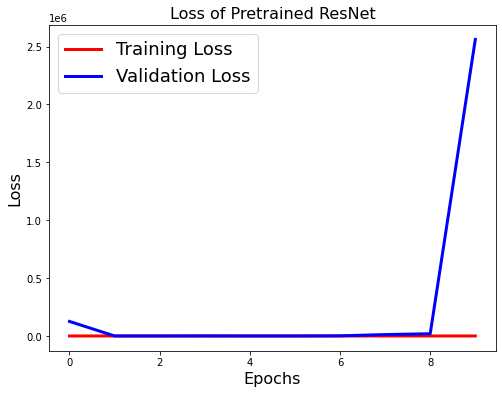

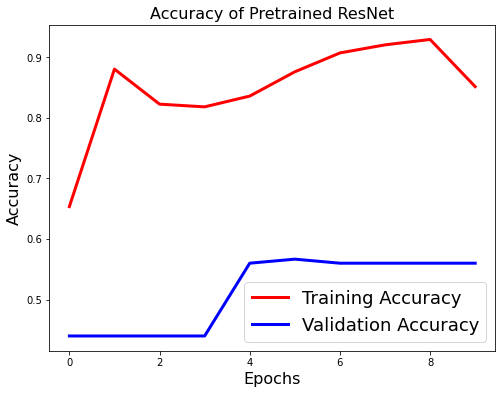

In [82]:
test_Resnet(pretrained=True, freeze_layers=False, number_of_freezed_layers= 0, epochs=10, print_summary=True, plot_results=True, model_name="ResNet")

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6968a55b00> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f69690dab38> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6968aeaa58> True
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f6968aacf28> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f6968a6c278> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f6968a647f0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6968a64d68> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6968a1d198> True
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f6968a14d68> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f6968a41e48> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6968a41278> True
<tensorflow.python.keras.layers.normalization.

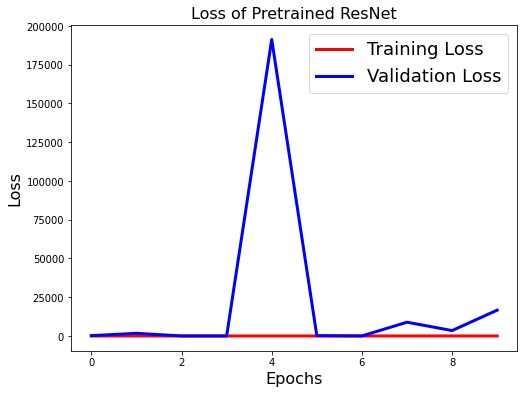

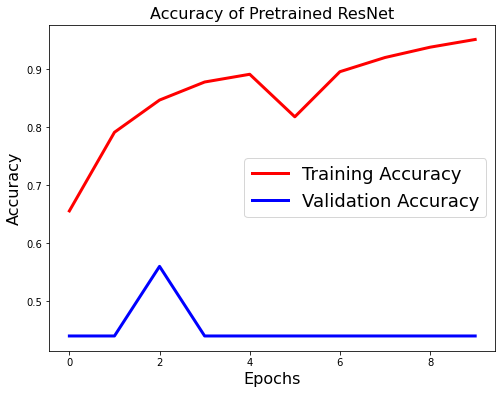

In [83]:
test_Resnet(pretrained=True, freeze_layers= True, number_of_freezed_layers= 5, epochs=10, print_summary=True, plot_results=True, model_name="ResNet")

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6968e00898> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f6964c76208> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6966d3ed68> True
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f69663c86d8> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f696643d400> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f696643db70> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f696643de80> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f69663e9ef0> True
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f69663f25f8> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f6966394be0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6966394e80> True
<tensorflow.python.keras.layers.normalization.

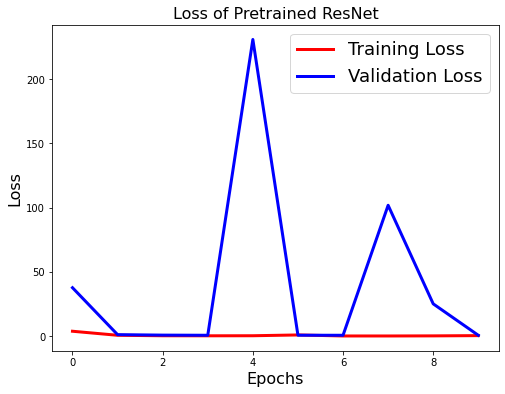

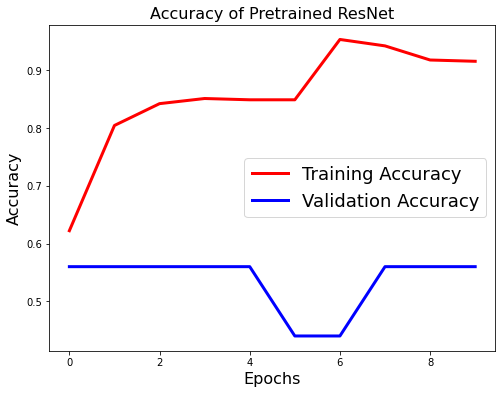

In [86]:
test_Resnet(pretrained=True, freeze_layers= True, number_of_freezed_layers= 10, epochs=10, print_summary=True, plot_results=True, model_name="ResNet")

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f696bd165c0> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f696bd16c18> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6968a51438> True
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f6968abf208> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f696bcbc780> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f6968a55a58> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f696bc65da0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f696bc19198> True
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f696bc13d68> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f696bc3fe48> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f696bc3f278> True
<tensorflow.python.keras.layers.normalization.

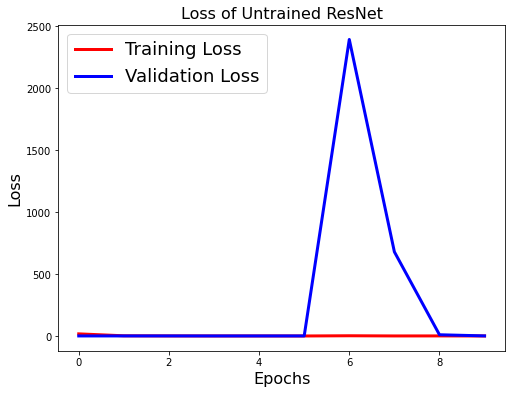

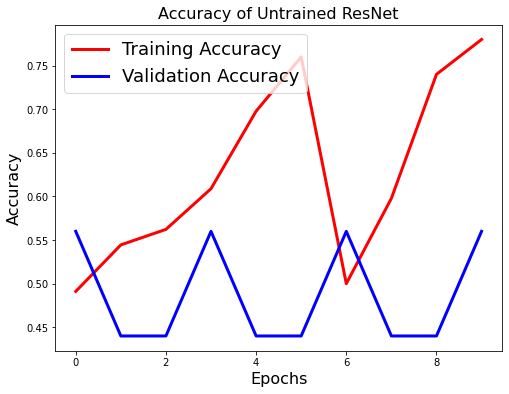

In [84]:
test_Resnet(pretrained=False, freeze_layers= True, number_of_freezed_layers= 10, epochs=10, print_summary=True, plot_results=True, model_name="ResNet")

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6968e00e10> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f6968e00630> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6968e00f28> True
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f6968e13358> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f696bcca208> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f6968e09828> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6968e09588> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6968dbac50> True
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f6968dba860> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f6968cdfe48> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6968ce9198> True
<tensorflow.python.keras.layers.normalization.

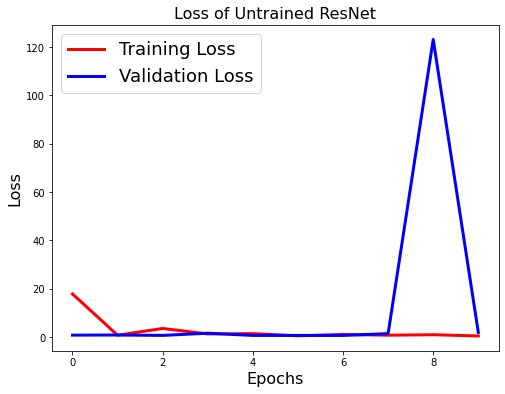

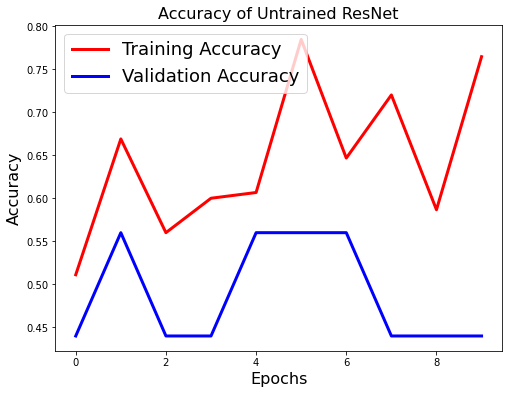

In [85]:
test_Resnet(pretrained=False, freeze_layers= True, number_of_freezed_layers= 15, epochs=10, print_summary=True, plot_results=True, model_name="ResNet")

# VGG

In [0]:
def test_VGG(pretrained=True, freeze_layers=False, number_of_freezed_layers=0, epochs=10, print_summary=True, plot_results=True, model_name="VGG"):
    if(pretrained):
        model_name = "Pretrained " + model_name
        base_model = applications.vgg16.VGG16(weights='imagenet', include_top=False,input_tensor=None,input_shape=input_shape ,pooling='none')

    else:
        model_name = "Untrained " + model_name
        base_model = applications.vgg16.VGG16(weights=None, include_top=False,input_tensor=None, input_shape=input_shape,pooling='none')

    if freeze_layers:
        base_model = freeze(base_model, number_of_freezed_layers)

    #define the top of your model (the output layers)
    vgg_model = tf.keras.Sequential()
    vgg_model.add(base_model)
    vgg_model.add(layers.Flatten())
    vgg_model.add(layers.Dense(1024, activation='relu'))
    vgg_model.add(layers.Dropout(0.5))
    #Output Layer
    # Sigmoid because it is a binary classification problem output (0,1)
    vgg_model.add(Dense(units = 1,kernel_initializer="uniform", activation='sigmoid'))

    test_model(vgg_model, model_name, epochs, print_summary, plot_results)

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_17 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 1025      
Total params: 16,813,889
Trainable params: 16,813,889
Non-trainable params: 0

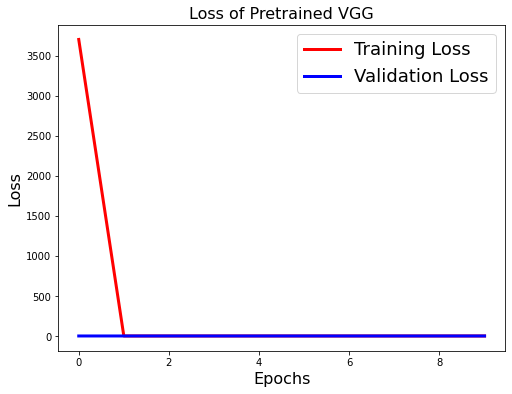

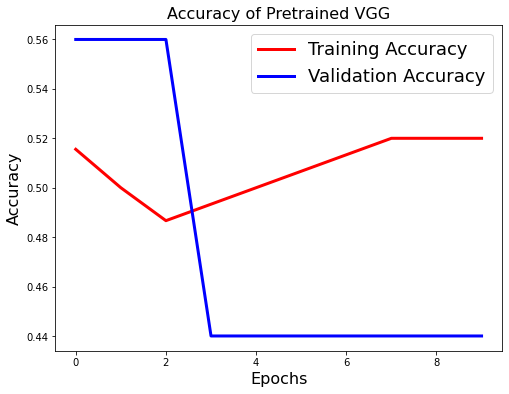

In [88]:
test_VGG(pretrained=True, freeze_layers=False, number_of_freezed_layers=0, epochs=10, print_summary=True, plot_results=True, model_name="VGG")


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f69652847b8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f69656ddeb8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f696641e8d0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f69651ae940> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6964c70b70> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f69651689e8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6965168d30> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6965167438> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f696517a780> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f696517aa20> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f696517fe48> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f696517f

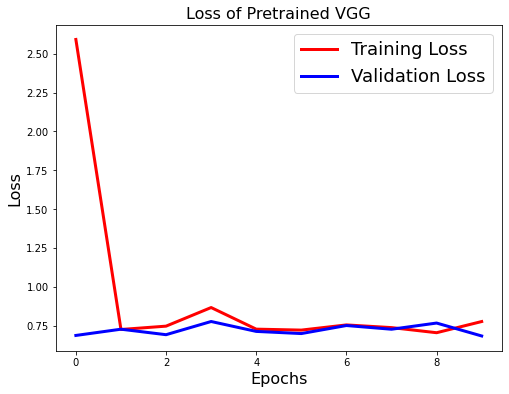

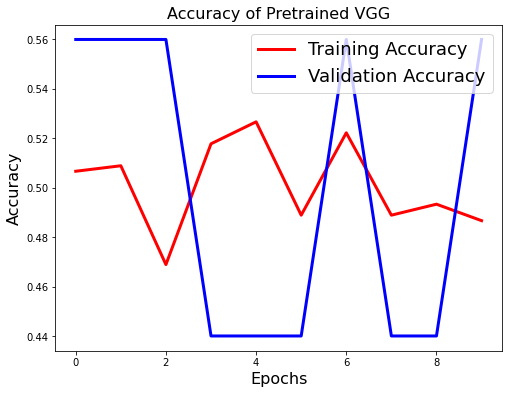

In [89]:
test_VGG(pretrained=True, freeze_layers=True, number_of_freezed_layers= 5, epochs=10, print_summary=True, plot_results=True, model_name="VGG")


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f696508ac18> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f69623edef0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f69634e50b8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f69623f4f60> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f69634dc9b0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f69634d6390> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f69623fa278> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f69623826a0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f696238b9e8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f696238bd30> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6962393940> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f69623

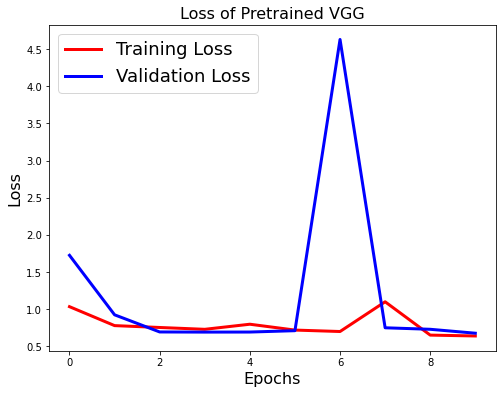

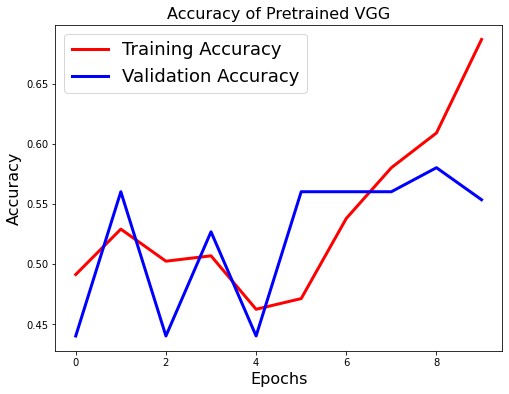

In [90]:
test_VGG(pretrained=True, freeze_layers=True, number_of_freezed_layers= 10, epochs=10, print_summary=True, plot_results=True, model_name="VGG")


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6960f09b38> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960be6940> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f69623d55c0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6960b79898> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960b7de48> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960b2deb8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6960bf3e48> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960bf3b70> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960ad9f28> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960adfe48> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6960adfe10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960a

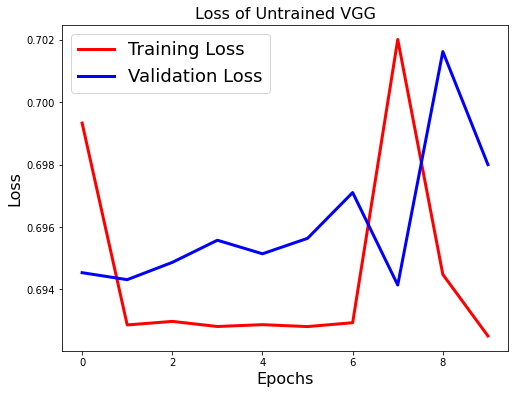

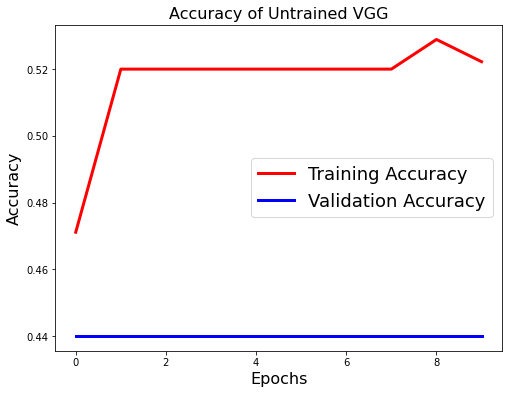

In [92]:
test_VGG(pretrained=False, freeze_layers=True, number_of_freezed_layers= 10, epochs=10, print_summary=True, plot_results=True, model_name="VGG")


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6965284748> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f69634d6400> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960f3c7f0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6960f6d1d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960f0d048> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960f17160> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6960f09438> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960f1e1d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960f2def0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6960f2deb8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f6960f34dd8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f

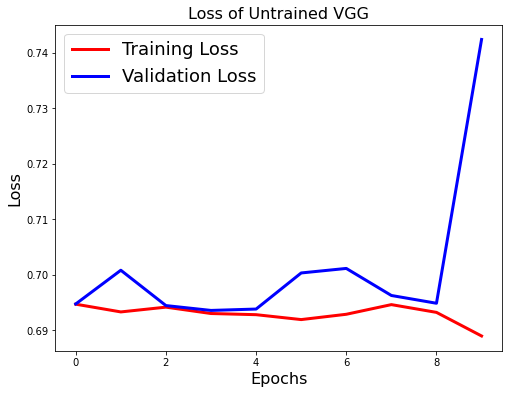

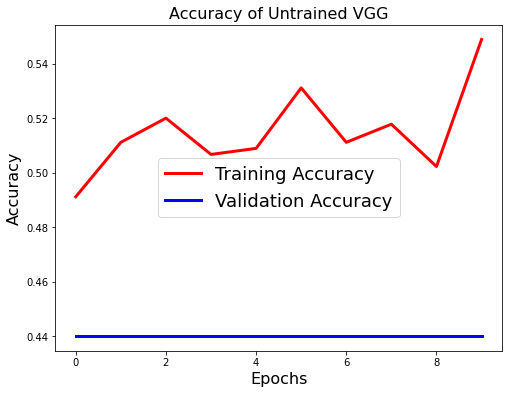

In [91]:
test_VGG(pretrained=False, freeze_layers=True, number_of_freezed_layers= 15, epochs=10, print_summary=True, plot_results=True, model_name="VGG")


# Huper Parameter Tuning 

In [0]:
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.Adamax, tf.keras.optimizers.RMSprop,
              tf.keras.optimizers.SGD]
lrs = [.01, .1, 1, 10, 100]
best_lr=.01
max_acc = -1
best_opt = tf.keras.optimizers.Adam(best_lr)
EPOCHS = 10 
BATCH_SIZE = 5

# Tune Optimizer


In [0]:
for optimizer in optimizers:
    model = HappyModel(input_shape)
    model.compile(optimizer=optimizer(best_lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(train_x, train_y, verbose = 0, epochs=EPOCHS, batch_size=BATCH_SIZE)
    score = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE)
    print(score)
    plot(history.history['accuracy'],validation_results = 0, results_type = 'Accuracy', model_name="CNN")
    if score[1] > max_acc:
        max_acc = score[1]
        best_opt = optimizer

In [0]:
print(best_opt)

# Tune Learning Rate

In [0]:
max_acc=-1
best_lr=1

In [0]:
for lr in lrs:
    model = HappyModel(input_shape)
    model.compile(optimizer=best_opt(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, Y_train, verbose = 0, epochs=EPOCHS, batch_size=BATCH_SIZE)
    score = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE)
    plot(history.history['accuracy'],validation_results = 0, results_type = 'Accuracy', model_name="CNN")
    if score[1] >= max_acc:
      max_acc = score[1]
      best_lr = lr

In [0]:
print(best_lr)

# Tune Loss Function 

In [0]:
losses = ['binary_crossentropy', 'categorical_crossentropy', 'categorical_hinge','mean_absolute_error','mean_absolute_percentage_error','mean_squared_error','mean_squared_logarithmic_error','sparse_categorical_crossentropy']

In [109]:
for loss in losses:
    model = HappyModel(input_shape)
    model.compile(optimizer=best_opt(best_lr), loss=loss, metrics=['accuracy'])
    history = model.fit(X_train, Y_train, verbose = 0, epochs=EPOCHS, batch_size=BATCH_SIZE)
    score = model.evaluate(X_val, Y_val, batch_size=BATCH_SIZE)
    plot(history.history['accuracy'],'Accuracy', "CNN")
    if score[1] >= max_acc:
        max_acc = score[1]
        best_lr = lr

TypeError: ignored